## Analyse en composantes Indépendantes (ICA)

L'analyse en composantes indépendantes est une méthode d'analyse des données. Elle est notoirement et historiquement connue en tant que méthode de séparation aveugle de source.

## Analyse en composantes principales (PCA)

L'analyse en composantes principales est une méthode qui consiste à transformer des variables liées entre elles (dites « corrélées » en statistique) en nouvelles variables décorrélées les unes des autres. Ces nouvelles variables sont nommées « composantes principales », ou axes principaux.

ICA http://www.nature.com/nature/journal/v439/n7079/full/nature04485.html

 * https://github.com/bicv/SHL_scripts 
 * n_dictionary = 9**2
 * N_X, N_Y = 2000, 1
 * patch_size = (256, 1)
 

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from ANEMO import read_edf
import numpy as np
%matplotlib inline

In [2]:
timeStr = '2017-09-20_151043'
observer = 's07'
mode = 'eyeMvt'

In [3]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [4]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [5]:
g = []
g_p = []
g_n = []
new_g = []
new_g_p = []
new_g_n = []

for block in range(N_blocks) :

    for trial in range(N_trials) :
        trial_data = trial + N_trials*block
        
        
        data_x = data[trial_data]['x']
        trackertime = data[trial_data]['trackertime']

        StimulusOf = data[trial_data]['events']['msg'][14][0] - trackertime[0]
        TargetOn = data[trial_data]['events']['msg'][15][0] - trackertime[0]
        TargetOff = data[trial_data]['events']['msg'][16][0] - trackertime[0]
        saccades = data[trial_data]['events']['Esac']
        
        gradient_x = np.gradient(data_x)
        
        g_x = []
        for t in range (len(trackertime)) :
            if t > StimulusOf-300 and t < StimulusOf + 1319 :
                g_x.append(gradient_x[t])
        g.append(g_x)
        
        # SUPPRESSION DES SACCADES
        new_gradient_x=[]
        new_time=[]
        t=0
        for x_data in range(len(data_x)):
            saccade = None
            for s in range(len(saccades)) :
                if x_data in np.arange((saccades[s][0]-trackertime[0]), (saccades[s][1]-trackertime[0]+1+4)) :
                    saccade = 'yes'
            if not saccade :
                new_gradient_x.append(gradient_x[x_data])
                new_time.append(t)
                t = t+1
            saccade = None
        
        # donne la StimulusOf avec la suppresion des saccades
        new_StimulusOf = StimulusOf
        for s in range(len(saccades)) :
            if StimulusOf > saccades[s][0]-trackertime[0] :
                new_StimulusOf = new_StimulusOf - saccades[s][2]
        new_gx = []
        for t in range (len(new_time)) :
            if t > new_StimulusOf-300 and t < new_StimulusOf + 600 :
                new_gx.append(new_gradient_x[t])
        new_g.append(new_gx)
        
        if p[trial, block, 0] == 1 :
            g_p.append(g_x)
            new_g_p.append(new_gx)
        else :
            g_n.append(g_x)
            new_g_n.append(new_gx)

In [6]:
g = np.asarray(g)
g_p = np.asarray(g_p)
g_n = np.asarray(g_n)
new_g = np.asarray(new_g)
new_g_p = np.asarray(new_g_p)
new_g_n = np.asarray(new_g_n)

print (g.shape, g_p.shape, g_n.shape)
print(new_g.shape, new_g_p.shape, new_g_n.shape) # attention tous les signaux doivent faire la même taille !!!

(800, 1618) (426, 1618) (374, 1618)
(800, 899) (426, 899) (374, 899)


# Test avec Sklearn

In [7]:
from sklearn.decomposition import FastICA, PCA

## Test ICA

In [8]:
xComponents = 4

In [9]:
# ICA
ica = FastICA(n_components=xComponents)
ica_g = ica.fit_transform(g.T)
ica_g_p = ica.fit_transform(g_p.T)
ica_g_n = ica.fit_transform(g_n.T)

ica_new_g = ica.fit_transform(new_g.T)
ica_new_g_p = ica.fit_transform(new_g_p.T)
ica_new_g_n = ica.fit_transform(new_g_n.T)

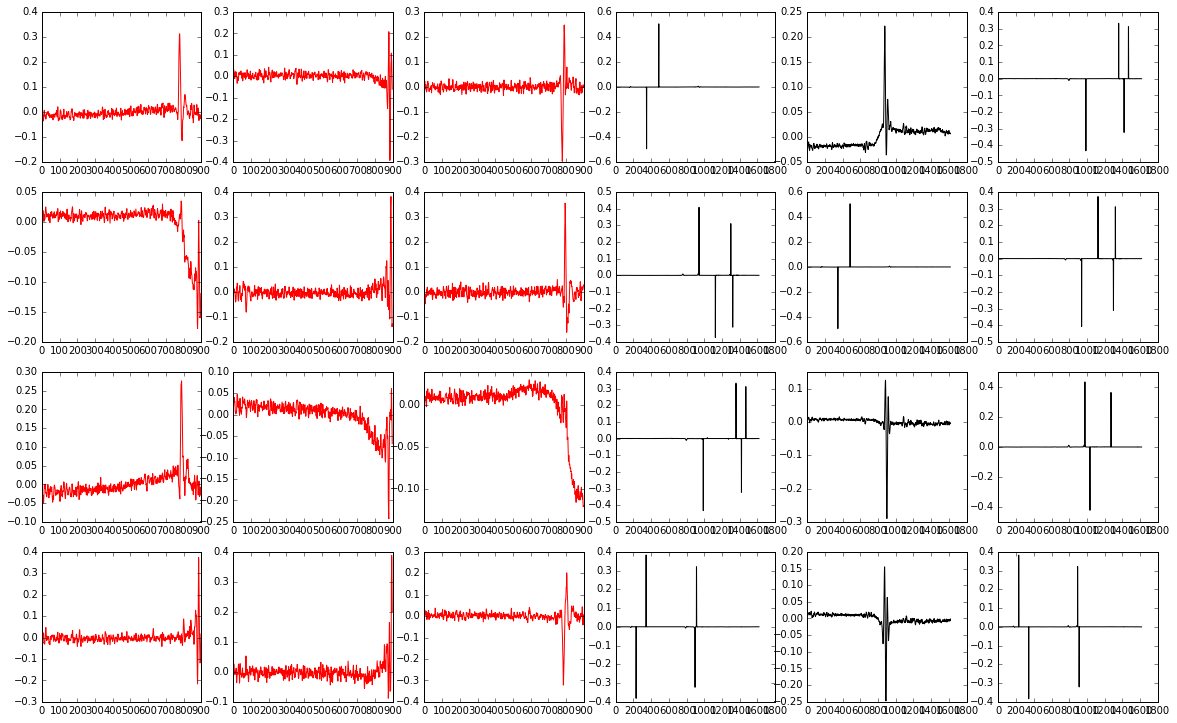

In [10]:
fig_width= 20
fig, axs = plt.subplots(xComponents, 6,figsize=(fig_width, (fig_width/1.6180)))

for x in range(xComponents):
    axs[x][0].plot(ica_new_g[:, x], c='r')
    axs[x][1].plot(ica_new_g_p[:, x], c='r')
    axs[x][2].plot(ica_new_g_n[:, x], c='r')
    
    axs[x][3].plot(ica_g[:, x], c='k')
    axs[x][4].plot(ica_g_p[:, x], c='k')
    axs[x][5].plot(ica_g_n[:, x], c='k')
plt.show()

## Test PCA

In [11]:
pca = PCA(n_components=xComponents)
pca_g = pca.fit_transform(g.T)
pca_g_p = pca.fit_transform(g_p.T)
pca_g_n = pca.fit_transform(g_n.T)

pca_new_g = pca.fit_transform(new_g.T)
pca_new_g_p = pca.fit_transform(new_g_p.T)
pca_new_g_n = pca.fit_transform(new_g_n.T)

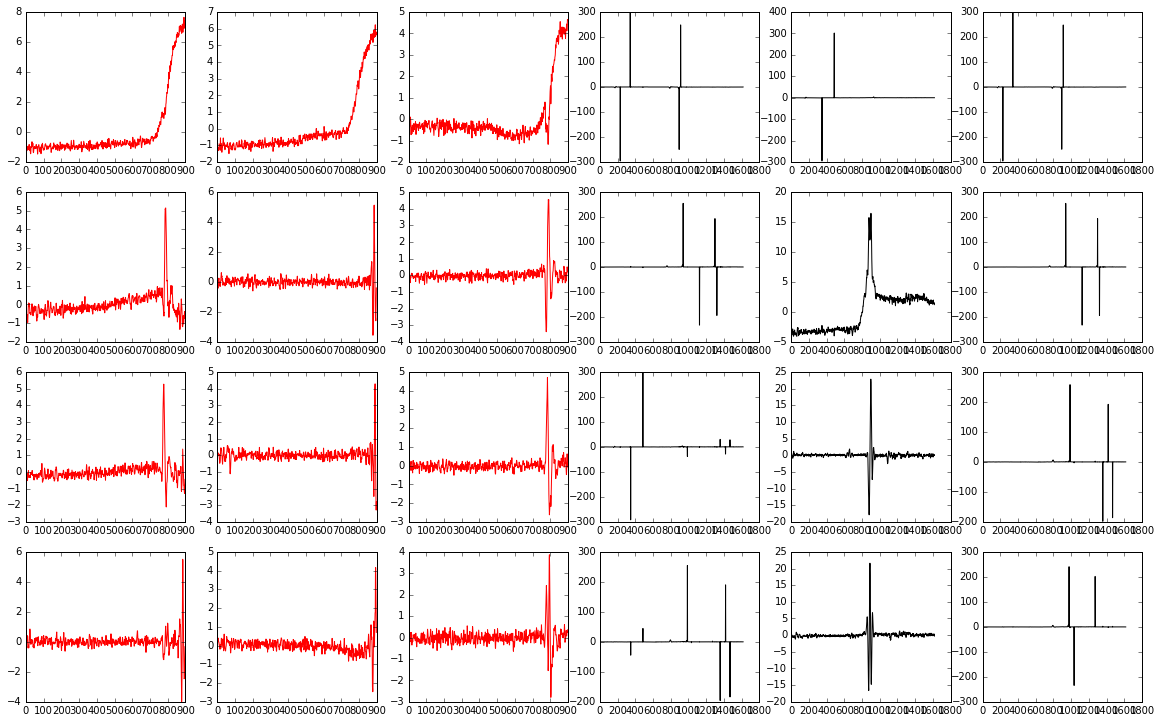

In [12]:
fig_width= 20
fig, axs = plt.subplots(xComponents, 6,figsize=(fig_width, (fig_width/1.6180)))

for x in range(xComponents):
    axs[x][0].plot(pca_new_g[:, x], c='r')
    axs[x][1].plot(pca_new_g_p[:, x], c='r')
    axs[x][2].plot(pca_new_g_n[:, x], c='r')
    
    axs[x][3].plot(pca_g[:, x], c='k')
    axs[x][4].plot(pca_g_p[:, x], c='k')
    axs[x][5].plot(pca_g_n[:, x], c='k')
plt.show()